In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def generate_data(n, mean_a, sigma_a, mean_b, sigma_b, bias=True, random_seed=None, percentA=1, percentB=1, last=False):
    """
    Generates synthetic data for two classes.
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    if last==False:
        class_a = np.random.randn(2, n*percentA) * sigma_a + np.array(mean_a).reshape(2, 1)
        class_b = np.random.randn(2, n*percentB) * sigma_b + np.array(mean_b).reshape(2, 1)
    else:
        class_a = np.zeros((2, n))
        class_a[0, :n // 2] = np.random.randn(1, n // 2) * sigma_a - mean_a[0]
        class_a[0, n // 2:] = np.random.randn(1, n // 2) * sigma_a + mean_a[0]
        class_a[1, :] = np.random.randn(1, n) * sigma_a + mean_a[1]

        class_b = np.zeros((2, n))
        class_b[0, :] = np.random.randn(1, n) * sigma_b + mean_b[0]
        class_b[1, :] = np.random.randn(1, n) * sigma_b + mean_b[1]

    labels_perceptron = np.concatenate((np.zeros(n*percentA), np.ones(n*percentB)))
    labels_delta = np.concatenate((-np.ones(n*percentA), np.ones(n*percentB)))

    merged_data = np.concatenate((class_a, class_b), axis=1)
    x_bias = np.ones(n*percentA + n*percentB)
    merged_data = np.vstack((x_bias, merged_data))

    return np.vstack((merged_data, labels_perceptron, labels_delta))

In [4]:
def plot_data_and_boundary(data, weights, title, bias=True):
    """
    Plots data points and decision boundary.
    """
    labels = data[3].astype(bool)
    plt.scatter(data[1, ~labels], data[2, ~labels], color='blue', label='Class A')
    plt.scatter(data[1, labels], data[2, labels], color='red', label='Class B')

    x_values = np.linspace(-4, 4, 100)
    if len(weights)==3:
        y_values = -(weights[1] / weights[2]) * x_values - (weights[0] / weights[2])
    else:
        y_values = -(weights[0] / weights[1]) * x_values
    plt.plot(x_values, y_values, label=title)
    if bias==False:
        plt.axhline(0, color='black', linewidth=0.4)
        plt.axvline(0, color='black', linewidth=0.4)

    plt.xlabel('X values')
    plt.ylabel('Y values')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.title('Data and Decision Boundary')
    plt.legend()
    plt.show()

In [5]:
def plot_missclassification_rates(missclass_rates, eta_values, title):
    """
    Plots missclassification rates over epochs for different eta values.
    """
    for missclass_rate, eta in zip(missclass_rates, eta_values):
        plt.plot(missclass_rate, label=f'eta = {eta}')
    plt.xlabel('Epoch')
    plt.ylabel('Miss-classification rate')
    plt.legend()
    plt.title(title)
    plt.show()

In [6]:
def initialize_weights(n=3, random_seed=None):
    """
    Initializes weights randomly.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    return np.random.normal(0, 1, n)

In [7]:
def perceptron_learning(weights, x, target, eta):
    """
    Performs perceptron weight update.
    """
    prediction = np.dot(weights, x)
    if prediction < 0 and target == 1 or prediction > 0 and target == 0:
        weights += eta * (target - (prediction > 0)) * x
    return weights

In [8]:
def delta_rule_sequential(weights, x, target, eta):
    """
    Performs delta rule (sequential) weight update.
    """
    error = target - np.dot(weights, x)
    weights += eta * error * x
    return weights

In [9]:
def delta_rule_batch(weights, data, targets, eta):
    """
    Performs delta rule (batch) weight update.
    """
    errors = targets - np.dot(weights, data)
    weights += eta * np.dot(errors, data.T)
    return weights

In [10]:
def calculate_missclassification_rate(weights, data, labels, by_class=False):
    """
    Calculates the missclassification rate.
    """
    predictions = np.dot(weights, data) > 0
    if by_class==True:
        class_a_misclassification = np.mean(predictions[labels == 0] != labels[labels == 0])
        class_b_misclassification = np.mean(predictions[labels == 1] != labels[labels == 1])
        return class_a_misclassification, class_b_misclassification
    return np.mean(predictions != labels)

In [11]:
def run_simulation(epochs=100, eta_values=[0.1, 0.01, 0.001], random_seed=None):
    """
    Runs the simulation for different learning algorithms and eta values.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    data = generate_data(100, [1.0, 2.5], 0.5, [-1.0, -0.5], 0.5, random_seed=random_seed)
    data2 = generate_data(100, [1.0, 2.5], 0.5, [-1.0, -2.5], 0.5, random_seed=random_seed)


    X, labels_perceptron, labels_delta = data[:3, :], data[3], data[4]
    X_no_bias1, labels_perceptron_no_bias1 = data[1:3, :], data[3]
    X_no_bias2, labels_perceptron_no_bias2 = data2[1:3, :], data2[3]

    missclass_perceptron, missclass_perceptron_no_bias1, missclass_perceptron_no_bias2, missclass_delta, missclass_delta_batch = [], [], [], [], []

    for eta in eta_values:
        weights_init = initialize_weights(random_seed=random_seed)
        weights_perceptron, weights_perceptron_no_bias1, weights_perceptron_no_bias2, weights_delta, weights_delta_batch = [weights_init.copy() for _ in range(5)]
        weights_perceptron_no_bias1 = weights_perceptron_no_bias1[1:3]
        weights_perceptron_no_bias2 = weights_perceptron_no_bias2[1:3]

        missclass_rates_perceptron, missclass_rates_perceptron_no_bias1, missclass_rates_perceptron_no_bias2, missclass_rates_delta, missclass_rates_delta_batch = [], [], [], [], []

        for _ in range(epochs):
            for x, t_perc, t_delta in zip(X.T, labels_perceptron, labels_delta):
                weights_perceptron = perceptron_learning(weights_perceptron, x, t_perc, eta)
                weights_delta = delta_rule_sequential(weights_delta, x, t_delta, eta)

            for x, t_perc in zip(X_no_bias1.T, labels_perceptron_no_bias1):
                weights_perceptron_no_bias1 = perceptron_learning(weights_perceptron_no_bias1, x, t_perc, eta)

            for x, t_perc in zip(X_no_bias2.T, labels_perceptron_no_bias2):
                weights_perceptron_no_bias2 = perceptron_learning(weights_perceptron_no_bias2, x, t_perc, eta)

            missclass_rates_perceptron.append(
                calculate_missclassification_rate(weights_perceptron, X, labels_perceptron))
            missclass_rates_perceptron_no_bias1.append(calculate_missclassification_rate(weights_perceptron_no_bias1, X_no_bias1, labels_perceptron_no_bias1))
            missclass_rates_perceptron_no_bias2.append(calculate_missclassification_rate(weights_perceptron_no_bias2, X_no_bias2, labels_perceptron_no_bias2))
            missclass_rates_delta.append(calculate_missclassification_rate(weights_delta, X, labels_perceptron))
            missclass_rates_delta_batch.append(
                calculate_missclassification_rate(weights_delta_batch, X, labels_perceptron))

            weights_delta_batch = delta_rule_batch(weights_delta_batch, X, labels_delta, eta)

        missclass_perceptron.append(missclass_rates_perceptron)
        missclass_perceptron_no_bias1.append(missclass_rates_perceptron_no_bias1)
        missclass_perceptron_no_bias2.append(missclass_rates_perceptron_no_bias2)
        missclass_delta.append(missclass_rates_delta)
        missclass_delta_batch.append(missclass_rates_delta_batch)

    plot_missclassification_rates(missclass_perceptron, eta_values, 'Perceptron')
    plot_missclassification_rates(missclass_perceptron_no_bias1, eta_values, 'Perceptron, no bias')
    plot_missclassification_rates(missclass_perceptron_no_bias2, eta_values, 'Perceptron, no bias, linearly separable')
    plot_missclassification_rates(missclass_delta, eta_values, 'Sequential Delta Rule')
    plot_missclassification_rates(missclass_delta_batch, eta_values, 'Batch Delta Rule')

    plot_data_and_boundary(data, weights_delta_batch, 'Delta Rule Batch Boundary')
    plot_data_and_boundary(data, weights_delta, 'Delta Rule Boundary')
    plot_data_and_boundary(data, weights_perceptron, 'Perceptron Boundary')
    plot_data_and_boundary(data, weights_perceptron_no_bias1, 'Perceptron Boundary No Bias', bias=False)
    plot_data_and_boundary(data2, weights_perceptron_no_bias2, 'Perceptron Boundary No Bias, Linearly Separable Data', bias=False)

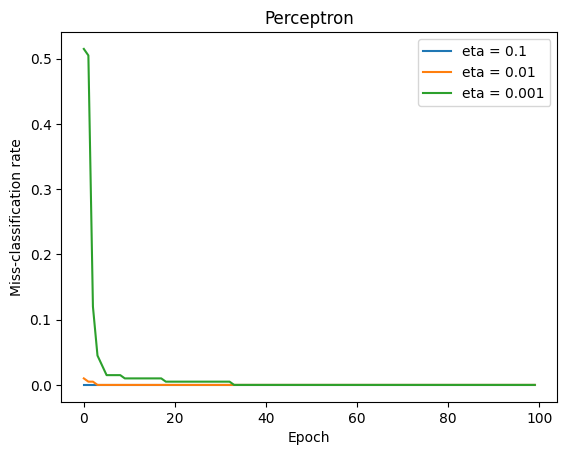

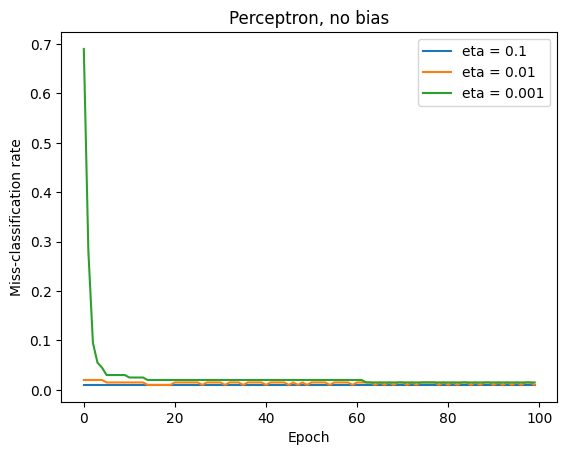

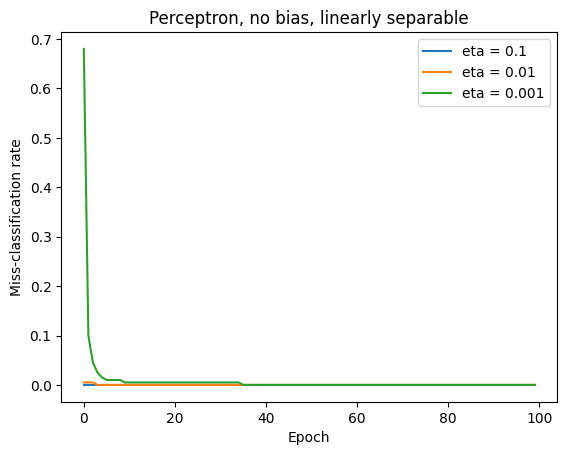

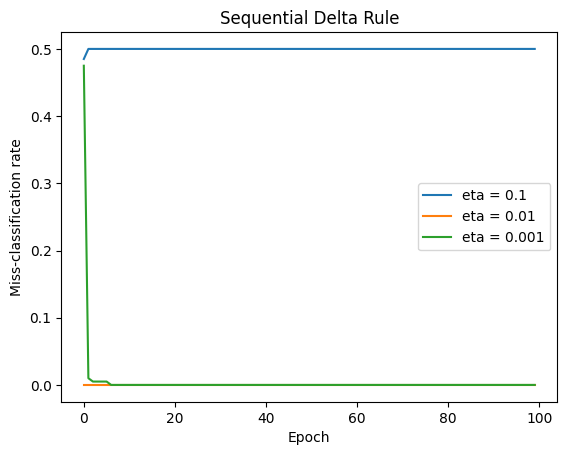

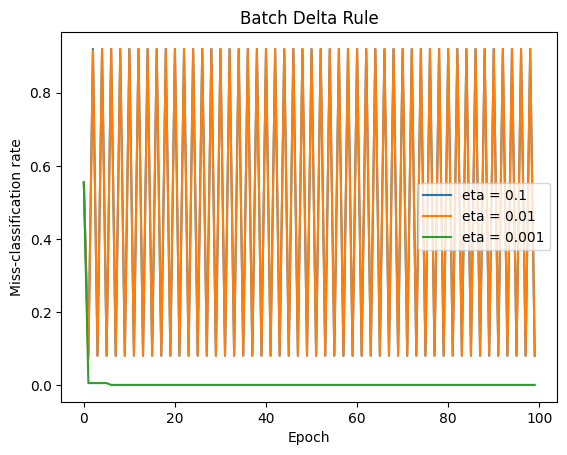

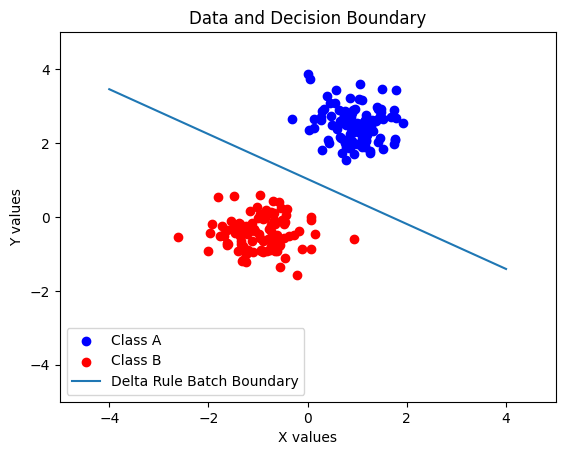

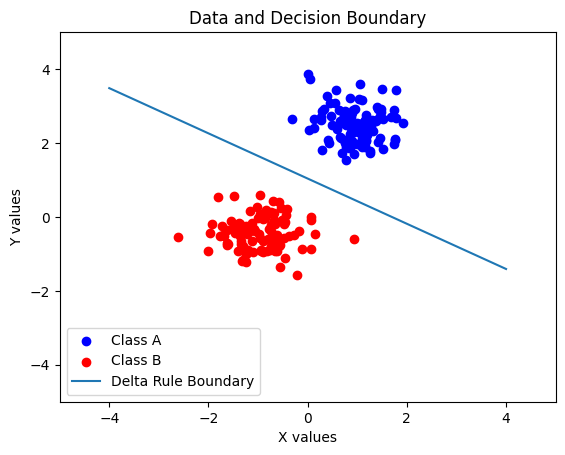

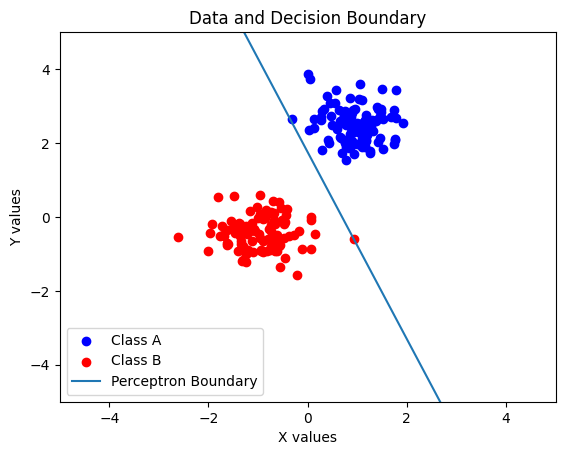

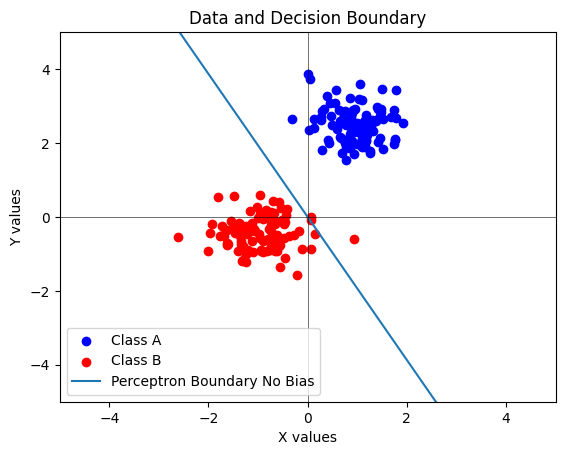

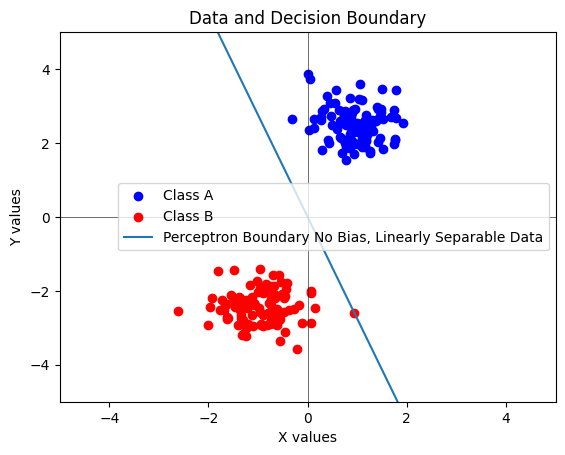

In [12]:
run_simulation(random_seed=42)